## Sensible heat flux depends not only on windspeed, but also on near surface temperature gradient. 
That's computed as TBOT - TS; the lowest level temperature in CAM and the surface temperature. So just writing a quick script to compute that and save it out for thirty years of the simulation. 

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib as matplotlib
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob


## 1. Set up file names 

In [3]:
# Set up directories 
dataDir    = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd_sfcT   = '_TS.nc'
nameEnd_atmT   = '_Tlevs.nc'

# Using fewer years here for comparison 
decadeList = ['1970-79','1980-89','1990-99']


## 2. Read in data

In [4]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    TSfile        = dataDir+nameStart+decadeList[iDec]+nameEnd_sfcT
    tsDF          = xr.open_dataset(TSfile, decode_times=True)
    tsDF['time']  = tsDF.indexes['time'].to_datetimeindex()
    
    atmTfile      = dataDir+nameStart+decadeList[iDec]+nameEnd_atmT
    atmDF         = xr.open_dataset(atmTfile, decode_times=True)
    atmDF['time']  = atmDF.indexes['time'].to_datetimeindex()

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullTS   = tsDF
        fullT    = atmDF
    else:
        fullTS   = xr.concat([fullTS,   tsDF], dim="time")
        fullT    = xr.concat([fullT,   atmDF], dim="time")
        
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    

<ipython-input-4-72e24249a535>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tsDF['time']  = tsDF.indexes['time'].to_datetimeindex()
<ipython-input-4-72e24249a535>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  atmDF['time']  = atmDF.indexes['time'].to_datetimeindex()


Done with decade  1970-79  ... 
Done with decade  1980-89  ... 
Done with decade  1990-99  ... 


In [11]:
# Isolate variables
TS    = fullTS.TS.values 
T     = fullT.T.values

# Flip along vertical (level) axis, so that index 0 is surface 
T   = np.flip(T,   axis=1)

# Save levels themselves to arrays and flip them too (avoids confusion later, hopefully)
lev_middle    = np.flip(fullT.lev.values)

# Save bottom CAM level temperature (index=0 now that it's flipped)
TBOT = T[:,0,:,:]


## 3. Compute gradient (TBOT - TS)

In [14]:
delT = TBOT - TS 
np.shape(delT)

(360, 192, 288)

In [19]:
# Sanity check this works as expected... 
print('TBOT: %.3f' % TBOT [100,43,250])
print('TS:   %.3f' % TS   [100,43,250])
print('diff: %.3f' % (TBOT[100,43,250] - 
                        TS[100,43,250]))
print('delT: %.3f' %  delT[100,43,250])


TBOT: 278.665
TS:   280.596
diff: -1.931
delT: -1.931


**Additional sanity check: mean JJA temperature gradients**

In [35]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullTS['time'].values) 

# Let's set the monthly averages to be roughly mid-month
#   This way, the average for January has a month of 1 instead of being the first day of February 
midTime = dates - timedelta(days=15) 

# Get iJJA
iJJA = np.where((midTime.month>=6)  & (midTime.month<=8))[0]


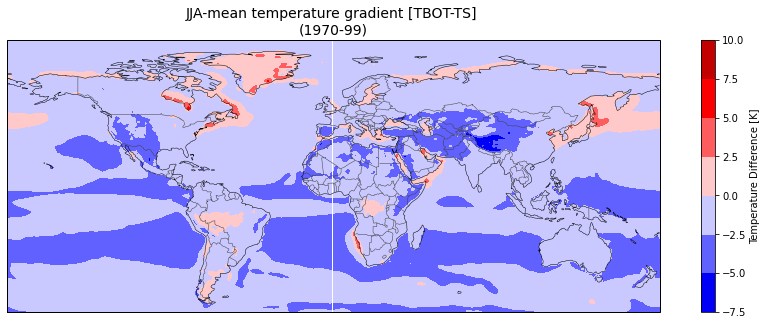

In [43]:
# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(15, 5),subplot_kw={'projection':ccrs.PlateCarree()})
# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

cmap = ax1.contourf(fullTS.lon.values,fullTS.lat.values,np.nanmean(delT[iJJA,:,:],axis=0),
                   cmap='seismic',
                   vmin=-12,vmax=12)
fig.colorbar(cmap,label='Temperature Difference [K]')

ax1.set_title('JJA-mean temperature gradient [TBOT-TS] \n(1970-99)',fontsize=14)
plt.show()


## 4. Save temperature gradient to pickle file 

In [20]:
fileOut = dataDir+nameStart+'1970-99_gradT.p'


In [21]:
pickle.dump( delT, open( fileOut, "wb" ) )


# Do the same with daily data

## 1. Set up file names and read in data

In [2]:
# Set up directories 
dataDir     = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/daily/'
nameStart   = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.'
nameEnd_sfcT   = '_TSprecip.nc'
nameEnd_atmT   = '_dailyT.nc'

# Using fewer years here for comparison 
decadeList = ['1970-79','1980-89','1990-99']


In [ ]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    TSfile        = dataDir+nameStart+decadeList[iDec]+nameEnd_sfcT
    tsDF          = xr.open_dataset(TSfile, decode_times=True)
    tsDF['time']  = tsDF.indexes['time'].to_datetimeindex()
    
    atmTfile      = dataDir+nameStart+decadeList[iDec]+nameEnd_atmT
    atmDF         = xr.open_dataset(atmTfile, decode_times=True)
    atmDF['time']  = atmDF.indexes['time'].to_datetimeindex()

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullTS   = tsDF
        fullT    = atmDF
    else:
        fullTS   = xr.concat([fullTS,   tsDF], dim="time")
        fullT    = xr.concat([fullT,   atmDF], dim="time")
        
        
    print('Done with decade ', decadeList[iDec], ' ... ')


<ipython-input-3-e146b218fb15>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tsDF['time']  = tsDF.indexes['time'].to_datetimeindex()
<ipython-input-3-e146b218fb15>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  atmDF['time']  = atmDF.indexes['time'].to_datetimeindex()


Done with decade  1970-79  ... 


In [ ]:
# Isolate variables
TS    = fullTS.TS.values 
T     = fullT.T.values

# Flip along vertical (level) axis, so that index 0 is surface 
T   = np.flip(T,   axis=1)

# Save levels themselves to arrays and flip them too (avoids confusion later, hopefully)
lev_middle    = np.flip(fullT.lev.values)

# Save bottom CAM level temperature (index=0 now that it's flipped)
TBOT = T[:,0,:,:]

# Remove profiles of T from memory 
del T

## 2. Compute the gradient in T and sanity check

In [ ]:
delT = TBOT - TS 
np.shape(delT)


In [ ]:
# Sanity check this works as expected... 
print('TBOT: %.3f' % TBOT [100,43,250])
print('TS:   %.3f' % TS   [100,43,250])
print('diff: %.3f' % (TBOT[100,43,250] - 
                        TS[100,43,250]))
print('delT: %.3f' %  delT[100,43,250])


In [ ]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullTS['time'].values) 

# Let's set the monthly averages to be roughly mid-month
#   This way, the average for January has a month of 1 instead of being the first day of February 
midTime = dates - timedelta(days=15) 

# Get iJJA
iJJA = np.where((midTime.month>=6)  & (midTime.month<=8))[0]


In [ ]:
# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(15, 5),subplot_kw={'projection':ccrs.PlateCarree()})
# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

cmap = ax1.contourf(fullTS.lon.values,fullTS.lat.values,np.nanmean(delT[iJJA,:,:],axis=0),
                   cmap='seismic',
                   vmin=-12,vmax=12)
fig.colorbar(cmap,label='Temperature Difference [K]')

ax1.set_title('JJA-mean temperature gradient [TBOT-TS] \n(1970-99)',fontsize=14)
plt.show()


## 3. Save out to pickle file

In [ ]:
fileOut = dataDir+nameStart+'1970-99_gradT_daily.p'

pickle.dump( delT, open( fileOut, "wb" ) )
